<a href="https://colab.research.google.com/github/yeseong9769/BigData-Project-Stock/blob/main/%EB%B9%85%EB%8D%B0%EC%9D%B4%ED%84%B0_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 데이터 수집, 가공, 정제

##1.1 증권별 네이버 증권 뉴스 크롤링

In [ ]:
from bs4 import BeautifulSoup
from tqdm import tqdm
import re
import datetime
import requests
import pandas as pd

# 종목 이름을 입력했다면 코드로 변환하는 함수
def convert_input_to_code(input_text, stock_data):
    pattern = '[a-zA-Z가-힣]+'
    if bool(re.match(pattern, input_text)):
        stock_code = stock_data.loc[stock_data['회사명'] == input_text, '종목코드'].values[0]
    else:
        stock_code = str(input_text)

    return f'{stock_code:0>6}'        # ex) 삼성전자 '5930' -> '005930' 변환

# 크롤링 후 csv 저장 함수
def crawl_and_save_news(company_code, start_date):
    page = 1

    with tqdm(desc='진행 중', unit='페이지') as pbar:         # 진행상황 표시
        while True:
            date_result, source_result, title_result = [], [], []

            url = f'https://finance.naver.com/item/news_news.nhn?code={company_code}&page={page}'
            response = requests.get(url)

            # 응답 코드가 200이 아닌경우 오류 출력
            if response.status_code != 200:
                print(f"Failed to fetch data from {url}. Status code: {response.status_code}")
                return None

            soup = BeautifulSoup(response.text, 'html.parser')
            news_table = soup.find('table', class_='type5')
            news_rows = news_table.find_all('tr')

            for idx, row in enumerate(news_rows):
                # 관련 뉴스는 제외
                if idx == 0:
                    continue
                if "class" in row.attrs and "relation_lst" in row["class"]:
                    continue
                if row.find_parent("tr", class_="relation_lst"):
                    continue

                # 제목, 언론사, 날짜 텍스트 추출
                title = row.find('td', class_='title').text.strip()
                info = row.find('td', class_='info').text.strip()
                date = row.find('td', class_='date').text.strip()

                # 날짜 텍스트를 날짜 데이터로 변환
                news_date = datetime.datetime.strptime(date, "%Y.%m.%d %H:%M")

                # 사용자가 지정한 날짜와 가져온 뉴스의 날짜를 비교
                if news_date >= start_date:
                    date_result.append(news_date)
                    source_result.append(info)
                    title_result.append(title)
                else:
                    # 만약 시작 날짜보다 더 전인경우, 크롤링 중단
                    break

            # 사용자가 지정한 날짜 이후의 뉴스가 없는경우 중단
            if not date_result:
                break

            result = {"날짜": date_result, "언론사": source_result, "기사제목": title_result}
            df_result = pd.DataFrame(result)

            # 첫페이지만 헤더를 적용하기 위한 코드
            mode = 'w' if page == 1 else 'a'
            header = page == 1

            df_result.to_csv(
                f"{company_code}_news.csv",
                mode=mode,
                encoding='utf-8-sig',
                header=header,
                index=False
            )

            pbar.update(1)
            page += 1

    return f"{company_code}_news.csv"

# 종목 데이터(종목이름, 종목코드) 불러오기
stock_data = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download', header=0)[0]
stock_data = stock_data.iloc[:, :2]

# 사용자 입력(종목, 날짜)
#input_text = input('종목코드 또는 종목이름을 입력: ')
#input_date = input('크롤링을 시작할 날짜 입력 (YYYYMMDD): ')
input_text = "005930"
input_date = "20230905"
start_date = datetime.datetime.strptime(input_date, "%Y%m%d")

# 사용자 입력 종목 -> 코드 변환
stock_code = convert_input_to_code(input_text, stock_data)

# 크롤링 후 데이터 저장
file_path = crawl_and_save_news(stock_code, start_date)

if file_path:
    print(f"\n{file_path}에 저장되었습니다.")
else:
    print("\n크롤링 작업이 실패했습니다.")

진행 중: 394페이지 [06:30,  1.01페이지/s]


005930_news.csv에 저장되었습니다.


##1.2 날자별 종목 지수 데이터 수집

[*********************100%%**********************]  1 of 1 completed
               Open     High      Low    Close  Adj Close    Volume
Date                                                               
2023-11-13  71300.0  71300.0  70300.0  70400.0    70400.0   9246919
2023-11-14  71000.0  71100.0  70600.0  70800.0    70800.0   9567984
2023-11-15  71600.0  72200.0  71500.0  72200.0    72200.0  20148677
2023-11-16  72500.0  73000.0  72300.0  72800.0    72800.0  15860451
2023-11-17  72300.0  73000.0  72300.0  72500.0    72500.0  11494644


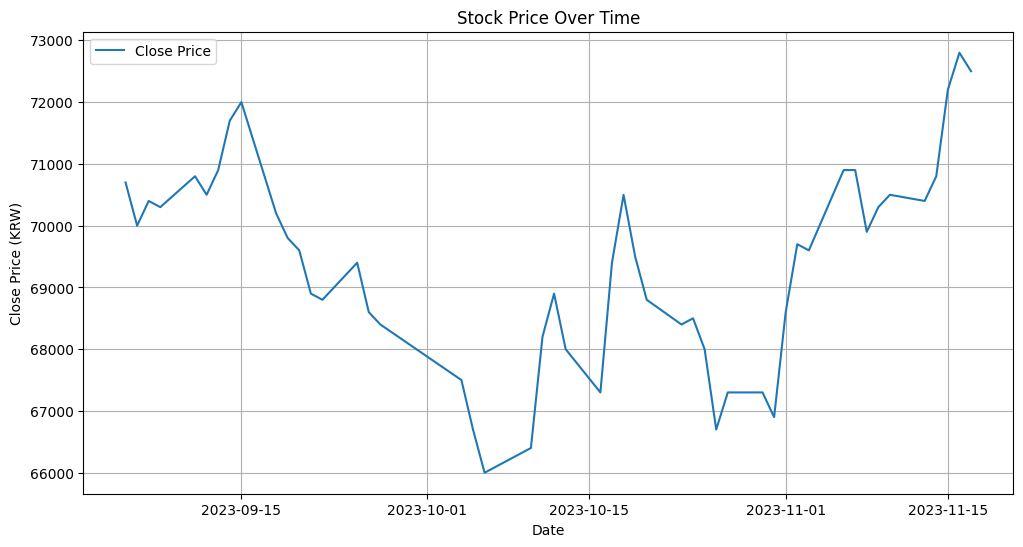

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt

df = yf.download(stock_code + ".KS", start=start_date.strftime("%Y-%m-%d"), end=datetime.datetime.today())
print(df.tail())

plt.figure(figsize=(12,6))
plt.plot(df['Close'], label='Close Price')
plt.title('Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price (KRW)')
plt.legend()
plt.grid(True)
plt.show()

#2. 데이터 분석

##2.1 감성분석 모델을 이용한 뉴스 분류

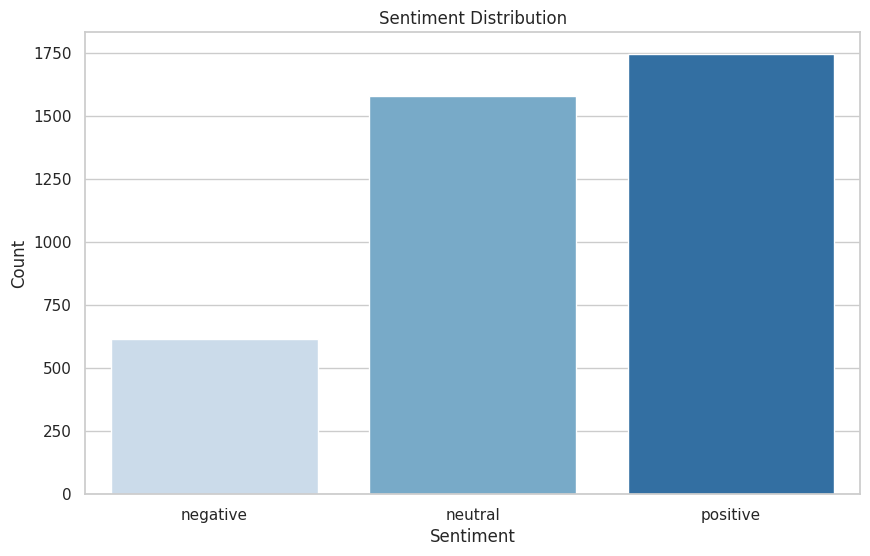

In [ ]:
!pip install transformers
from transformers import pipeline
import seaborn as sns

sentiment_pipe = pipeline(model='snunlp/KR-FinBert-SC')

df = pd.read_csv(file_path)
headline = df['기사제목'].tolist()

senti_headline = pd.DataFrame(sentiment_pipe(headline))
df.set_index('date')
df['senti'] = senti_headline['label']
df['sentiscore'] = senti_headline['score']

df.to_csv(file_path)

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.countplot(x='senti', data=df, palette='Blues')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

##2.2 감성 계량화

In [ ]:
df['score'] = df['senti'] + df['sentiscore']

plt.figure(figsize=(16,4))
sns.scatterplot(x=df.index, y=df['score'])
plt.show()

##2.3 주가 데이터 스케일링

# Reference

김유신, 김남규, 정승렬. (2012). 뉴스와 주가 : 빅데이터 감성분석을 통한 지능형 투자의사결정모형. 지능정보연구, 18(2), 143-156.

이예지. "뉴스 빅데이터 분석을 통한 종목별 주가예측." 국내석사학위논문 충북대학교, 2014. 충청북도

https://songseungwon.tistory.com/124

https://github.com/CSJ516/Stock_Prediction_project

https://github.com/seyoongit/news

https://github.com/park-gb/financial-news-sentiment-classifier/blob/main/sentiment_classifier.ipynb